In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 00:16:49.182467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 00:16:50.852015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 4260
end_idx = 4500
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(240, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(240, 96, 7)
(161280,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(240, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(240, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 00:17:01.757793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 00:17:05.097058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step
CPU time: 6426.290913725039 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

8/8 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.88976557 0.32754586 0.07145534 ... 0.12916687 0.94076241 0.78617157]
Fitness value of the best solution = 0.0026575569373623975


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

8/8 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


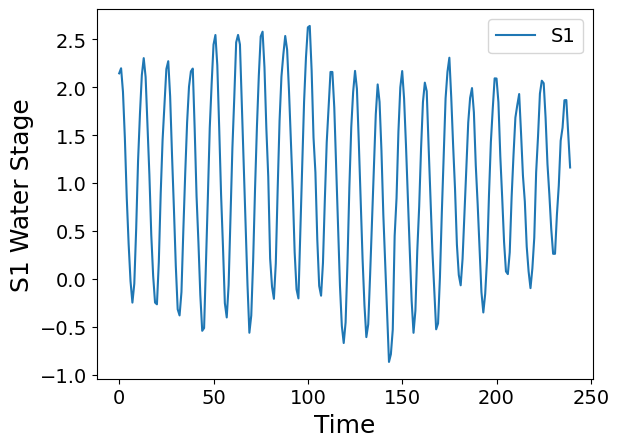

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low6.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.889766,0.327546,0.071455,0.733899,0.676847,0.697750,0.337728,0.648995,0.885193,0.656964,...,0.907155,0.003803,0.469401,0.033139,0.920879,0.961093,0.245999,0.941376,0.534669,0.483373
1,0.577246,0.660192,0.743489,0.418271,0.730121,0.044480,0.216708,0.888086,0.944035,0.030491,...,0.391190,0.013054,0.618505,0.984338,0.014995,0.556114,0.789500,0.831563,0.176738,0.846604
2,0.116029,0.548894,0.954232,0.148479,0.465775,0.697155,0.449976,0.144152,0.037290,0.360842,...,0.224804,0.371852,0.577414,0.983283,0.477234,0.616508,0.065144,0.068096,0.824830,0.689542
3,0.797282,0.907918,0.603353,0.991456,0.921653,0.315678,0.859389,0.899043,0.522795,0.182009,...,0.965323,0.089356,0.246590,0.566196,0.656679,0.178378,0.947881,0.943946,0.182783,0.737241
4,0.762815,0.649211,0.672581,0.983813,0.677766,0.405611,0.087941,0.682494,0.895266,0.368884,...,0.484261,0.141885,0.013818,0.864820,0.790487,0.883242,0.574144,0.852479,0.099196,0.884134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.840054,0.782743,0.023068,0.274451,0.896374,0.708005,0.888443,0.404604,0.337661,0.838790,...,0.375961,0.492716,0.324832,0.386619,0.441460,0.797423,0.422658,0.844143,0.575717,0.526916
236,0.594353,0.811055,0.571195,0.325132,0.375410,0.232721,0.486875,0.876912,0.433735,0.472324,...,0.851008,0.783099,0.575060,0.936669,0.919961,0.731178,0.547657,0.865642,0.733234,0.933618
237,0.683764,0.371070,0.667377,0.795814,0.409054,0.767573,0.203361,0.507498,0.730482,0.132906,...,0.230273,0.520395,0.909222,0.923546,0.854335,0.761485,0.366870,0.433468,0.429027,0.989625
238,0.317134,0.856389,0.226111,0.282146,0.910059,0.482471,0.713474,0.350110,0.398475,0.127793,...,0.201297,0.762798,0.908342,0.009114,0.732873,0.043491,0.417661,0.633648,0.802718,0.127879


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low6.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.145937,2.388729,2.191447,2.133394,2.291509,2.044660,2.336751,2.337742,1.993967,1.964525,...,0.189230,0.192993,0.742482,0.778307,0.749027,0.811510,1.360930,1.173856,1.372111,1.417235
1,2.198923,2.248060,2.221732,2.271147,1.924526,2.227831,2.016039,2.062067,1.464926,1.640991,...,0.610735,0.575022,1.268720,1.444981,1.164201,1.219817,1.677347,2.000101,1.605097,1.657494
2,1.952316,1.801743,2.004169,1.966527,1.492827,1.348834,1.487622,1.567876,0.965021,1.022463,...,1.170493,1.284870,1.701666,1.597774,1.637244,1.743033,2.009791,2.233204,1.912119,2.036536
3,1.471631,1.629003,1.555577,1.522534,1.020368,0.935173,1.031122,1.057554,0.304373,0.118680,...,1.695316,1.837789,2.122833,2.138716,2.143931,2.226311,2.208654,2.245978,2.172822,2.268572
4,0.847480,0.586772,0.777818,0.777906,0.515080,0.241056,0.543819,0.608624,-0.098509,-0.206815,...,2.077697,2.140414,2.166714,2.269516,2.183437,2.222712,1.923710,2.119479,2.062192,2.084870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.578752,1.336749,1.521263,1.542511,1.804208,1.596314,1.616794,1.785160,1.840863,1.612155,...,0.424342,0.424686,0.619123,0.743413,0.781404,0.726178,0.890730,0.919396,0.969954,0.979048
236,1.865006,1.840947,1.868886,1.849563,1.828106,1.714583,1.820176,1.846282,1.534078,1.609554,...,0.742559,0.693249,1.012537,0.995583,1.042222,1.061281,1.341311,1.581579,1.427709,1.431863
237,1.867023,1.999772,1.928405,1.924172,1.614156,1.796679,1.672468,1.717753,1.251264,1.197593,...,0.920399,0.964947,1.255933,1.346622,1.283537,1.342478,1.462958,1.694595,1.570256,1.566592
238,1.521725,1.612538,1.604444,1.590925,1.158898,1.320574,1.159611,1.238340,0.870222,0.736306,...,1.230600,1.326152,1.536339,1.517596,1.526911,1.651898,1.501538,1.437827,1.560510,1.650084


In [35]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 3197, areas: 806.1344174680635


In [38]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

8/8 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 4918, areas: 1768.1074189645005
